In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from scipy.stats import percentileofscore

## Note to TAs:
my code should run with no issues. The last cells with /0 errors are not issues since those values are not at >90% significance anyways. The only place I access outside files is in the cell right below where I access the downloaded Kaggle file.

### Load data from .sqlite file

In [2]:
# Connect to the SQLite database
conn = sqlite3.connect('wildfires.sqlite')

# Create a cursor object
cursor = conn.cursor()

# Fetch the table names from the database
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
table_names = cursor.fetchall()

# Select the first table name
table_name = table_names[21][0]  # Assuming there is at least one table in the database

In [3]:
# Execute a query to fetch data from the selected table
cursor.execute(f"SELECT * FROM {table_name}")

# Fetch all the results and store them as a list of tuples
data = cursor.fetchall()

# Get column names from cursor description
columns = [col[0] for col in cursor.description]

# Close the cursor and the connection
cursor.close()
conn.close()

# Create a DataFrame from the fetched data
df_all_cols = pd.DataFrame(data, columns=columns)

In [4]:
df = df_all_cols[['FOD_ID','FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'STATE', 'FIRE_NAME', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'FIRE_YEAR', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE', 'FIRE_SIZE']]
df = df[(df.get('FIRE_SIZE_CLASS') == 'F') | (df.get('FIRE_SIZE_CLASS') == 'G')].reset_index().drop(columns = 'index')
df.head()

,FOD_ID,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,FIRE_NAME,DISCOVERY_DATE,DISCOVERY_DOY,FIRE_YEAR,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,FIRE_SIZE
0,17,G,38.523333,-120.211667,CA,POWER,2453284.5,280,2004,2.0,Equipment Use,2453299.5,16823.0
1,18,G,38.780000,-120.260000,CA,FREDS,2453291.5,287,2004,2.0,Equipment Use,2453295.5,7700.0
2,192,G,33.723333,-111.275000,AZ,THREE,2453542.5,172,2005,1.0,Lightning,2453550.5,16100.0
3,556,F,35.688056,-118.438333,CA,NINE,2453560.5,190,2005,9.0,Miscellaneous,2453561.5,1149.0
4,590,F,33.933611,-111.379722,AZ,OAK,2453567.5,197,2005,1.0,Lightning,2453571.5,1300.0


#### Outline of what the code below achieves

* Plotting change in frequency of wildfires over time
    - Compare this within different regions/seasons
    - Perform a hypothesis test to determine if some regions have different peak times and different frequencies, also to determine maximum confidence by which we can say that wildfires have increased in frequency

### Filter fires by region, season, and region+season

In [5]:
northeast = ['ME', 'NH', 'VT', 'MA', 'RI', 'CT', 'NY', 'NJ', 'PA']
midwest = ['OH', 'MI', 'IN', 'WI', 'IL', 'MN', 'IO', 'MO', 'ND', 'SD', 'NE', 'KS']
south = ['DE', 'MD', 'VI', 'WV', 'KY', 'NC', 'SC', 'TN', 'GA', 'FL', 'AL', 'MS', 'AR', 'LA', 'TX', 'OK']
west = ['MT', 'ID', 'WY', 'CO', 'NM', 'AZ', 'UT', 'NV', 'CA', 'OR', 'WA']
#from US Census Bureau: https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf
#exclues AK + HI for simiplicity

#winter = days 354-365 + 0-78
#spring = days 79-170
#summer = days 171-262
#fall = days 263-353

In [6]:
northeast_df = df[df['STATE'].isin(northeast)]
midwest_df = df[df['STATE'].isin(midwest)]
south_df = df[df['STATE'].isin(south)]
west_df = df[df['STATE'].isin(west)]

In [7]:
winter = df[(df.get('DISCOVERY_DOY') >= 354) | (df.get('DISCOVERY_DOY') <= 78)]
spring = df[(df.get('DISCOVERY_DOY') >= 79) & (df.get('DISCOVERY_DOY') <= 170)]
summer = df[(df.get('DISCOVERY_DOY') >= 171) & (df.get('DISCOVERY_DOY') <= 262)]
fall = df[(df.get('DISCOVERY_DOY') >= 263) & (df.get('DISCOVERY_DOY') <= 353)]

In [8]:
winter_ne = northeast_df[(northeast_df.get('DISCOVERY_DOY') >= 354) | (northeast_df.get('DISCOVERY_DOY') <= 78)]
spring_ne = northeast_df[(northeast_df.get('DISCOVERY_DOY') >= 79) & (northeast_df.get('DISCOVERY_DOY') <= 170)]
summer_ne = northeast_df[(northeast_df.get('DISCOVERY_DOY') >= 171) & (northeast_df.get('DISCOVERY_DOY') <= 262)]
fall_ne = northeast_df[(northeast_df.get('DISCOVERY_DOY') >= 263) & (northeast_df.get('DISCOVERY_DOY') <= 353)]

In [9]:
winter_mw = midwest_df[(midwest_df.get('DISCOVERY_DOY') >= 354) | (midwest_df.get('DISCOVERY_DOY') <= 78)]
spring_mw = midwest_df[(midwest_df.get('DISCOVERY_DOY') >= 79) & (midwest_df.get('DISCOVERY_DOY') <= 170)]
summer_mw = midwest_df[(midwest_df.get('DISCOVERY_DOY') >= 171) & (midwest_df.get('DISCOVERY_DOY') <= 262)]
fall_mw = midwest_df[(midwest_df.get('DISCOVERY_DOY') >= 263) & (midwest_df.get('DISCOVERY_DOY') <= 353)]

In [10]:
winter_s = south_df[(south_df.get('DISCOVERY_DOY') >= 354) | (south_df.get('DISCOVERY_DOY') <= 78)]
spring_s = south_df[(south_df.get('DISCOVERY_DOY') >= 79) & (south_df.get('DISCOVERY_DOY') <= 170)]
summer_s = south_df[(south_df.get('DISCOVERY_DOY') >= 171) & (south_df.get('DISCOVERY_DOY') <= 262)]
fall_s = south_df[(south_df.get('DISCOVERY_DOY') >= 263) & (south_df.get('DISCOVERY_DOY') <= 353)]

In [11]:
winter_w = west_df[(west_df.get('DISCOVERY_DOY') >= 354) | (west_df.get('DISCOVERY_DOY') <= 78)]
spring_w = west_df[(west_df.get('DISCOVERY_DOY') >= 79) & (west_df.get('DISCOVERY_DOY') <= 170)]
summer_w = west_df[(west_df.get('DISCOVERY_DOY') >= 171) & (west_df.get('DISCOVERY_DOY') <= 262)]
fall_w = west_df[(west_df.get('DISCOVERY_DOY') >= 263) & (west_df.get('DISCOVERY_DOY') <= 353)]

### Compare seaonality and regionality of fires

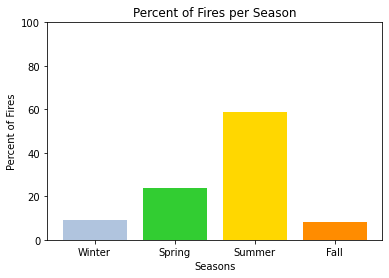

In [12]:
#Percent of fires per season
winter_fires = round(100*winter.shape[0]/df.shape[0],1)
spring_fires = round(100*spring.shape[0]/df.shape[0],1)
summer_fires = round(100*summer.shape[0]/df.shape[0],1)
fall_fires = round(100*fall.shape[0]/df.shape[0],1)

#plot fires / season
fig, ax = plt.subplots()
ax.bar(['Winter','Spring','Summer','Fall'], [winter_fires, spring_fires, summer_fires, fall_fires], 
       color = ['lightsteelblue','limegreen','gold','darkorange'])
ax.set_xlabel('Seasons')
ax.set_ylabel('Percent of Fires')
ax.set_ylim(0, 100)
ax.set_title('Percent of Fires per Season')
plt.show()

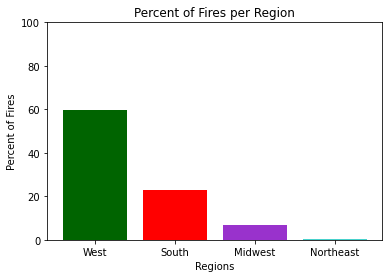

In [13]:
#Percent of fires per region
ne_fires = round(100*northeast_df.shape[0]/df.shape[0],1)
mw_fires = round(100*midwest_df.shape[0]/df.shape[0],1)
s_fires = round(100*south_df.shape[0]/df.shape[0],1)
w_fires = round(100*west_df.shape[0]/df.shape[0],1)

#plot fires / region
fig, ax = plt.subplots()
ax.bar(['West','South','Midwest','Northeast'], [w_fires, s_fires, mw_fires, ne_fires], 
       color = ['darkgreen','red','darkorchid','mediumturquoise'])
ax.set_xlabel('Regions')
ax.set_ylabel('Percent of Fires')
ax.set_ylim(0, 100)
ax.set_title('Percent of Fires per Region')
plt.show()

In [14]:
#Percent of fires in NE per season
winter_in_ne = round(100*winter_ne.shape[0]/northeast_df.shape[0],1)
spring_in_ne = round(100*spring_ne.shape[0]/northeast_df.shape[0],1)
summer_in_ne = round(100*summer_ne.shape[0]/northeast_df.shape[0],1)
fall_in_ne = round(100*fall_ne.shape[0]/northeast_df.shape[0],1)
ne_season_fires = [winter_in_ne,spring_in_ne,summer_in_ne,fall_in_ne]

#Percent of fires in MW per season
winter_in_mw = round(100*winter_mw.shape[0]/midwest_df.shape[0],1)
spring_in_mw = round(100*spring_mw.shape[0]/midwest_df.shape[0],1)
summer_in_mw = round(100*summer_mw.shape[0]/midwest_df.shape[0],1)
fall_in_mw = round(100*fall_mw.shape[0]/midwest_df.shape[0],1)
mw_season_fires = [winter_in_mw,spring_in_mw,summer_in_mw,fall_in_mw]

#Percent of fires in S per season
winter_in_s = round(100*winter_s.shape[0]/south_df.shape[0],1)
spring_in_s = round(100*spring_s.shape[0]/south_df.shape[0],1)
summer_in_s = round(100*summer_s.shape[0]/south_df.shape[0],1)
fall_in_s = round(100*fall_s.shape[0]/south_df.shape[0],1)
s_season_fires = [winter_in_s,spring_in_s,summer_in_s,fall_in_s]

#Percent of fires in W per season
winter_in_w = round(100*winter_w.shape[0]/west_df.shape[0],1)
spring_in_w = round(100*spring_w.shape[0]/west_df.shape[0],1)
summer_in_w = round(100*summer_w.shape[0]/west_df.shape[0],1)
fall_in_w = round(100*fall_w.shape[0]/west_df.shape[0],1)
w_season_fires = [winter_in_w,spring_in_w,summer_in_w,fall_in_w]

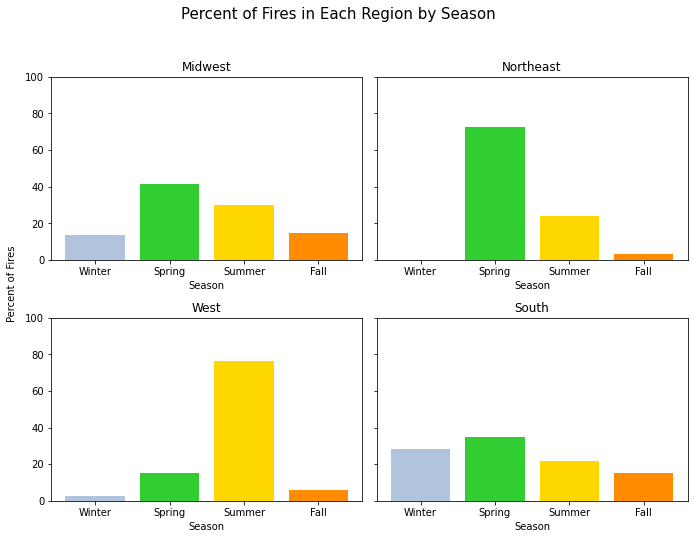

In [15]:
#plot all regions' seasonal frequencies onto same plot
seasons = ['Winter', 'Spring', 'Summer', 'Fall']
all_season_regions = [mw_season_fires,ne_season_fires,w_season_fires,s_season_fires]
fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharey=True)
sub_titles = ['Midwest','Northeast','West','South']
for ax, sub_title, region in zip(axs.flat, sub_titles, all_season_regions):
    ax.bar(['Winter', 'Spring', 'Summer', 'Fall'], region, color=['lightsteelblue','limegreen','gold','darkorange'])
    ax.set_title(sub_title)
    ax.set_ylim(0, 100)
    ax.set_xlabel('Season')
fig.text(0.04, 0.5, 'Percent of Fires', va='center', rotation='vertical')
fig.suptitle('Percent of Fires in Each Region by Season',size=15.0)
fig.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.show()

### Examine change in frequency over time / region, season, region+season

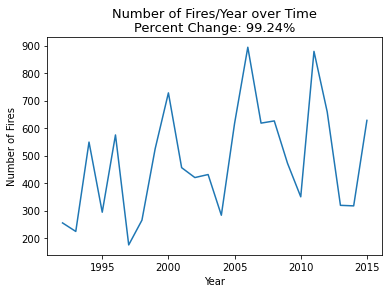

In [18]:
df_years = df.groupby('FIRE_YEAR').count()
plt.plot(df_years.reset_index().get('FIRE_YEAR').to_numpy(), df_years.get('FOD_ID').to_numpy())
plt.title('Number of Fires/Year over Time')
plt.xlabel('Year')
plt.ylabel('Number of Fires')

#calculate change over time
bootstrap_df = df_years.reset_index().rename(columns={'index':'FIRE_YEAR'})
actual_df = smf.ols('FOD_ID ~ FIRE_YEAR', bootstrap_df).fit()
change_df = round(actual_df.params[1]*24,2)
change_df = round(100*change_df / bootstrap_df.get('FOD_ID').to_numpy()[0],2)
plt.title('Number of Fires/Year over Time\nPercent Change: ' + str(change_df) + '%',size=13.0);

In [19]:
#fires/region over time
west_all_years = west_df.groupby('FIRE_YEAR').count()
years = west_all_years.reset_index().get('FIRE_YEAR').to_numpy()
west_years = west_all_years.get('FOD_ID').to_numpy()
south_years = south_df.groupby('FIRE_YEAR').count().get('FOD_ID').to_numpy()
midwest_years = midwest_df.groupby('FIRE_YEAR').count().get('FOD_ID').to_numpy()
#fill in values of 0 for northeast (not all years in the northeast have large fires)
northeast_years = northeast_df.groupby('FIRE_YEAR').count()
northeast_years = [5,0,0,3,0,1,0,1,0,1,2,0,1,0,1,2,4,1,1,0,1,0,3,2]

#each region gets a proportion of fires/year
all_regions = {'West': west_years,'South': south_years,
               'Midwest': midwest_years,'Northeast': northeast_years}
all_regions_df = pd.DataFrame(all_regions, index=years)
region_rows = all_regions_df.sum(axis=1)
all_regions_props = all_regions_df.div(region_rows, axis=0)
all_regions_props.head(1)

,West,South,Midwest,Northeast
1992,0.791667,0.133333,0.054167,0.020833


Text(0, 0.5, 'Number of Fires')

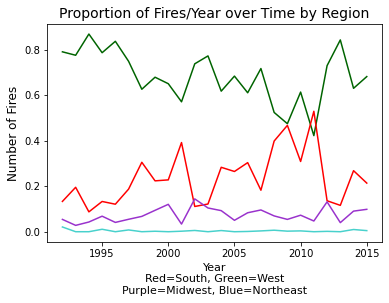

In [20]:
#plot all regions' change in frequency over time
plt.plot(years, all_regions_props.get('West').to_numpy(),color='darkgreen')
plt.plot(years, all_regions_props.get('South').to_numpy(),color='red')
plt.plot(years, all_regions_props.get('Midwest').to_numpy(),color='darkorchid')
plt.plot(years, all_regions_props.get('Northeast').to_numpy(),color='mediumturquoise')
plt.title('Proportion of Fires/Year over Time by Region',size=14.0)
plt.xlabel('Year\nRed=South, Green=West\nPurple=Midwest, Blue=Northeast',size=11.0)
plt.ylabel('Number of Fires',size=12.0)

In [21]:
#fires/season over time
winter_years = winter.groupby('FIRE_YEAR').count().get('FOD_ID').to_numpy()
spring_years = spring.groupby('FIRE_YEAR').count().get('FOD_ID').to_numpy()
summer_years = summer.groupby('FIRE_YEAR').count().get('FOD_ID').to_numpy()
fall_years = fall.groupby('FIRE_YEAR').count().get('FOD_ID').to_numpy()

#each season gets a proportion of fires/year
all_seasons = {'Winter': winter_years,'Spring': spring_years,
               'Summer': summer_years,'Fall': fall_years}
all_seasons_df = pd.DataFrame(all_seasons, index=years)
season_rows = all_seasons_df.sum(axis=1)
all_seasons_props = all_seasons_df.div(season_rows, axis=0)
all_seasons_props.head(1)

,Winter,Spring,Summer,Fall
1992,0.054902,0.219608,0.580392,0.145098


Text(0, 0.5, 'Number of Fires')

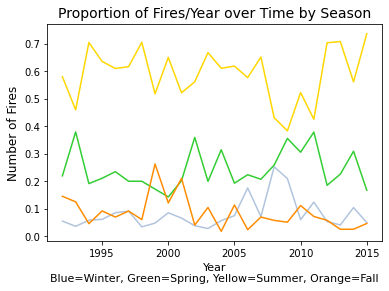

In [22]:
plt.plot(years, all_seasons_props.get('Winter').to_numpy(),color='lightsteelblue')
plt.plot(years, all_seasons_props.get('Spring').to_numpy(),color='limegreen')
plt.plot(years, all_seasons_props.get('Summer').to_numpy(),color='gold')
plt.plot(years, all_seasons_props.get('Fall').to_numpy(),color='darkorange')
plt.title('Proportion of Fires/Year over Time by Season',size=14.0)
plt.xlabel('Year\nBlue=Winter, Green=Spring, Yellow=Summer, Orange=Fall',size=11.0)
plt.ylabel('Number of Fires',size=12.0)

### Hypothesis Test

In [24]:
#bootstrap frequency of fires/time
#/season
def bootstrap_values(arr):
    random_slopes = np.zeros(5000)
    for i in np.arange(5000):
        chosen24 = random.sample(arr, 24)
        chosen24_df =  pd.DataFrame(chosen24, columns = ['samples'], index=years).reset_index().rename(columns={'index': 'year'})
        model = smf.ols('samples ~ year', chosen24_df).fit()
        random_slopes[i] = model.params[1]
    return random_slopes
def check100(perc):
    if perc<50:
        return 100-perc
    else:
        return perc

In [25]:
seasons_bootstrap = all_seasons_props.reset_index().rename(columns={'index':'year'})
#winter
actual_winter = smf.ols('Winter ~ year', seasons_bootstrap).fit()
change_winter = round(actual_winter.params[1]*24,2)
bootstrap_winter = bootstrap_values(list(all_seasons_props['Winter']))
percentile_winter = percentileofscore(bootstrap_winter, actual_winter.params[1])
percentile_winter = check100(percentile_winter)
change_winter = round(100*change_winter / seasons_bootstrap.get('Winter').to_numpy()[0],2)
print('Winter: percent change over time period: ' + str(change_winter)+'%')
print('boostrap significance', round(percentile_winter,2))
#spring
actual_spring = smf.ols('Spring ~ year', seasons_bootstrap).fit()
change_spring = round(actual_spring.params[1]*24,2)
bootstrap_spring = bootstrap_values(list(all_seasons_props['Spring']))
percentile_spring = percentileofscore(bootstrap_spring, actual_spring.params[1])
percentile_spring = check100(percentile_spring)
change_spring = round(100*change_spring / seasons_bootstrap.get('Spring').to_numpy()[0],2)
print('Spring: percent change over time period: ' + str(change_spring)+'%')
print('boostrap significance', round(percentile_spring,2))
#summer
actual_summer = smf.ols('Summer ~ year', seasons_bootstrap).fit()
change_summer = round(actual_summer.params[1]*24,2)
bootstrap_summer = bootstrap_values(list(all_seasons_props['Summer']))
percentile_summer = percentileofscore(bootstrap_summer, actual_summer.params[1])
percentile_summer = check100(percentile_summer)
change_summer = round(100*change_summer / seasons_bootstrap.get('Summer').to_numpy()[0],2)
print('Summer: percent change over time period: ' + str(change_summer)+'%')
print('boostrap significance', round(percentile_summer,2))
#fall
actual_fall = smf.ols('Fall ~ year', seasons_bootstrap).fit()
change_fall = round(actual_fall.params[1]*24,2)
bootstrap_fall = bootstrap_values(list(all_seasons_props['Fall']))
percentile_fall = percentileofscore(bootstrap_fall, actual_fall.params[1])
percentile_fall = check100(percentile_fall)
change_fall = round(100*change_fall / seasons_bootstrap.get('Fall').to_numpy()[0],2)
print('Fall: percent change over time period: ' + str(change_fall)+'%')
print('boostrap significance', round(percentile_fall,2))

Winter: percent change over time period: 109.29%
boostrap significance 92.18
Spring: percent change over time period: 18.21%
boostrap significance 77.6
Summer: percent change over time period: -1.72%
boostrap significance 55.82
Fall: percent change over time period: -62.03%
boostrap significance 98.2


In [26]:
regions_bootstrap = all_regions_props.reset_index().rename(columns={'index':'year'})
#west
actual_west = smf.ols('West ~ year', regions_bootstrap).fit()
change_west = round(actual_west.params[1]*24,2)
bootstrap_west = bootstrap_values(list(all_regions_props['West']))
percentile_west = percentileofscore(bootstrap_west, actual_west.params[1])
percentile_west = check100(percentile_west)
change_west = round(100*change_west / regions_bootstrap.get('West').to_numpy()[0],2)
print('West: percent change over time period: ' + str(change_west)+'%')
print('boostrap significance', round(percentile_west,2))
#south
actual_south = smf.ols('South ~ year', regions_bootstrap).fit()
change_south = round(actual_south.params[1]*24,2)
bootstrap_south = bootstrap_values(list(all_regions_props['South']))
percentile_south = percentileofscore(bootstrap_south, actual_south.params[1])
percentile_south = check100(percentile_south)
change_south = round(100*change_south / regions_bootstrap.get('South').to_numpy()[0],2)
print('South: percent change over time period: ' + str(change_south)+'%')
print('boostrap significance', round(percentile_south,2))
#midwest
actual_midwest = smf.ols('Midwest ~ year', regions_bootstrap).fit()
change_midwest = round(actual_midwest.params[1]*24,2)
bootstrap_midwest = bootstrap_values(list(all_regions_props['Midwest']))
percentile_midwest = percentileofscore(bootstrap_midwest, actual_midwest.params[1])
percentile_midwest = check100(percentile_midwest)
change_midwest = round(100*change_midwest / regions_bootstrap.get('Midwest').to_numpy()[0],2)
print('Midwest: percent change over time period: ' + str(change_midwest)+'%')
print('boostrap significance', round(percentile_midwest,2))
#northeast
actual_northeast = smf.ols('Northeast ~ year', regions_bootstrap).fit()
change_northeast = round(actual_northeast.params[1]*24,2)
bootstrap_northeast = bootstrap_values(list(all_regions_props['Northeast']))
percentile_northeast = percentileofscore(bootstrap_northeast, actual_northeast.params[1])
percentile_northeast = check100(percentile_northeast)
change_northeast = round(100*change_northeast / regions_bootstrap.get('Northeast').to_numpy()[0],2)
print('Northeast: percent change over time period: ' + str(change_northeast)+'%')
print('boostrap significance', round(percentile_northeast,5))

West: percent change over time period: -22.74%
boostrap significance 99.18
South: percent change over time period: 120.0%
boostrap significance 96.82
Midwest: percent change over time period: 55.38%
boostrap significance 92.9
Northeast: percent change over time period: -0.0%
boostrap significance 80.44


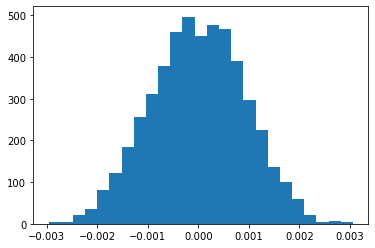

In [27]:
plt.hist(bootstrap_midwest, bins = 25);

### Change in proportion/time and hypothesis tests for each region's seasons
each cell must be run one after another since the variable names are the same for each region and the same as the total season variables

#### West

In [28]:
#fires/season over time
winter_years = winter_w.groupby('FIRE_YEAR').count().get('FOD_ID').to_numpy()
#not every year in the winter had a fire
winter_years = [ 6,  5, 12,  3,  7,  9,  2,  9, 18,  2,  7,  2,  2, 0, 19,  8, 14, 10, 2, 10,  8,  3,  4,  5]
spring_years = spring_w.groupby('FIRE_YEAR').count().get('FOD_ID').to_numpy()
summer_years = summer_w.groupby('FIRE_YEAR').count().get('FOD_ID').to_numpy()
fall_years = fall_w.groupby('FIRE_YEAR').count().get('FOD_ID').to_numpy()

#each season gets a proportion of fires/year
all_seasons = {'Winter': winter_years,'Spring': spring_years,
               'Summer': summer_years,'Fall': fall_years}
all_seasons_df = pd.DataFrame(all_seasons, index=years)
season_rows = all_seasons_df.sum(axis=1)
all_seasons_props = all_seasons_df.div(season_rows, axis=0)
all_seasons_props.head(1)

,Winter,Spring,Summer,Fall
1992,0.031579,0.184211,0.668421,0.115789


In [29]:
seasons_bootstrap = all_seasons_props.reset_index().rename(columns={'index':'year'})
#winter
actual_winter = smf.ols('Winter ~ year', seasons_bootstrap).fit()
change_winter = round(actual_winter.params[1]*24,2)
bootstrap_winter = bootstrap_values(list(all_seasons_props['Winter']))
percentile_winter = percentileofscore(bootstrap_winter, actual_winter.params[1])
percentile_winter = check100(percentile_winter)
change_winter = round(100*change_winter / seasons_bootstrap.get('Winter').to_numpy()[0],2)
print('Winter: percent change over time period: ' + str(change_winter)+'%')
print('boostrap significance', round(percentile_winter,2))
#spring
actual_spring = smf.ols('Spring ~ year', seasons_bootstrap).fit()
change_spring = round(actual_spring.params[1]*24,2)
bootstrap_spring = bootstrap_values(list(all_seasons_props['Spring']))
percentile_spring = percentileofscore(bootstrap_spring, actual_spring.params[1])
percentile_spring = check100(percentile_spring)
change_spring = round(100*change_spring / seasons_bootstrap.get('Spring').to_numpy()[0],2)
print('Spring: percent change over time period: ' + str(change_spring)+'%')
print('boostrap significance', round(percentile_spring,2))
#summer
actual_summer = smf.ols('Summer ~ year', seasons_bootstrap).fit()
change_summer = round(actual_summer.params[1]*24,2)
bootstrap_summer = bootstrap_values(list(all_seasons_props['Summer']))
percentile_summer = percentileofscore(bootstrap_summer, actual_summer.params[1])
percentile_summer = check100(percentile_summer)
change_summer = round(100*change_summer / seasons_bootstrap.get('Summer').to_numpy()[0],2)
print('Summer: percent change over time period: ' + str(change_summer)+'%')
print('boostrap significance', round(percentile_summer,2))
#fall
actual_fall = smf.ols('Fall ~ year', seasons_bootstrap).fit()
change_fall = round(actual_fall.params[1]*24,2)
bootstrap_fall = bootstrap_values(list(all_seasons_props['Fall']))
percentile_fall = percentileofscore(bootstrap_fall, actual_fall.params[1])
percentile_fall = check100(percentile_fall)
change_fall = round(100*change_fall / seasons_bootstrap.get('Fall').to_numpy()[0],2)
print('Fall: percent change over time period: ' + str(change_fall)+'%')
print('boostrap significance', round(percentile_fall,2))

Winter: percent change over time period: -31.67%
boostrap significance 80.3
Spring: percent change over time period: -16.29%
boostrap significance 71.74
Summer: percent change over time period: 17.95%
boostrap significance 93.14
Fall: percent change over time period: -60.45%
boostrap significance 99.18


#### South

In [30]:
#fires/season over time
winter_years = winter_s.groupby('FIRE_YEAR').count().get('FOD_ID').to_numpy()
spring_years = spring_s.groupby('FIRE_YEAR').count().get('FOD_ID').to_numpy()
summer_years = summer_s.groupby('FIRE_YEAR').count().get('FOD_ID').to_numpy()
fall_years = fall_s.groupby('FIRE_YEAR').count().get('FOD_ID').to_numpy()

#each season gets a proportion of fires/year
all_seasons = {'Winter': winter_years,'Spring': spring_years,
               'Summer': summer_years,'Fall': fall_years}
all_seasons_df = pd.DataFrame(all_seasons, index=years)
season_rows = all_seasons_df.sum(axis=1)
all_seasons_props = all_seasons_df.div(season_rows, axis=0)
all_seasons_props.head(1)

,Winter,Spring,Summer,Fall
1992,0.1875,0.21875,0.375,0.21875


In [31]:
seasons_bootstrap = all_seasons_props.reset_index().rename(columns={'index':'year'})
#winter
actual_winter = smf.ols('Winter ~ year', seasons_bootstrap).fit()
change_winter = round(actual_winter.params[1]*24,2)
bootstrap_winter = bootstrap_values(list(all_seasons_props['Winter']))
percentile_winter = percentileofscore(bootstrap_winter, actual_winter.params[1])
percentile_winter = check100(percentile_winter)
change_winter = round(100*change_winter / seasons_bootstrap.get('Winter').to_numpy()[0],2)
print('Winter: percent change over time period: ' + str(change_winter)+'%')
print('boostrap significance', round(percentile_winter,2))
#spring
actual_spring = smf.ols('Spring ~ year', seasons_bootstrap).fit()
change_spring = round(actual_spring.params[1]*24,2)
bootstrap_spring = bootstrap_values(list(all_seasons_props['Spring']))
percentile_spring = percentileofscore(bootstrap_spring, actual_spring.params[1])
percentile_spring = check100(percentile_spring)
change_spring = round(100*change_spring / seasons_bootstrap.get('Spring').to_numpy()[0],2)
print('Spring: percent change over time period: ' + str(change_spring)+'%')
print('boostrap significance', round(percentile_spring,2))
#summer
actual_summer = smf.ols('Summer ~ year', seasons_bootstrap).fit()
change_summer = round(actual_summer.params[1]*24,2)
bootstrap_summer = bootstrap_values(list(all_seasons_props['Summer']))
percentile_summer = percentileofscore(bootstrap_summer, actual_summer.params[1])
percentile_summer = check100(percentile_summer)
change_summer = round(100*change_summer / seasons_bootstrap.get('Summer').to_numpy()[0],2)
print('Summer: percent change over time period: ' + str(change_summer)+'%')
print('boostrap significance', round(percentile_summer,2))
#fall
actual_fall = smf.ols('Fall ~ year', seasons_bootstrap).fit()
change_fall = round(actual_fall.params[1]*24,2)
bootstrap_fall = bootstrap_values(list(all_seasons_props['Fall']))
percentile_fall = percentileofscore(bootstrap_fall, actual_fall.params[1])
percentile_fall = check100(percentile_fall)
change_fall = round(100*change_fall / seasons_bootstrap.get('Fall').to_numpy()[0],2)
print('Fall: percent change over time period: ' + str(change_fall)+'%')
print('boostrap significance', round(percentile_fall,2))

Winter: percent change over time period: 42.67%
boostrap significance 80.66
Spring: percent change over time period: 18.29%
boostrap significance 66.44
Summer: percent change over time period: 2.67%
boostrap significance 53.74
Fall: percent change over time period: -64.0%
boostrap significance 88.54


#### Midwest

In [32]:
#fires/season over time
winter_years = winter_mw.groupby('FIRE_YEAR').count().get('FOD_ID').to_numpy()
winter_years = [1,0,6,5,5,2,2,5,14,1,2,0,0,2,11,3,12,6,0,3,10,0,10,9]
spring_years = spring_mw.groupby('FIRE_YEAR').count().get('FOD_ID').to_numpy()
summer_years = summer_mw.groupby('FIRE_YEAR').count().get('FOD_ID').to_numpy()
summer_years = [0,1,2,7,4,0,5,1,41,6,24,14,3,12,49,17,3,0,2,5,42,0,2,1]
fall_years = fall_mw.groupby('FIRE_YEAR').count().get('FOD_ID').to_numpy()
fall_years = [7,3,1,3,1,1,3,28,10,2,0,3,0,1,3,7,3,3,2,16,11,1,5,5]

#each season gets a proportion of fires/year
all_seasons = {'Winter': winter_years,'Spring': spring_years,
               'Summer': summer_years,'Fall': fall_years}
all_seasons_df = pd.DataFrame(all_seasons, index=years)
season_rows = all_seasons_df.sum(axis=1)
all_seasons_props = all_seasons_df.div(season_rows, axis=0)
all_seasons_props.head(1)

,Winter,Spring,Summer,Fall
1992,0.076923,0.384615,0.0,0.538462


In [33]:
seasons_bootstrap = all_seasons_props.reset_index().rename(columns={'index':'year'})
#winter
actual_winter = smf.ols('Winter ~ year', seasons_bootstrap).fit()
change_winter = round(actual_winter.params[1]*24,2)
bootstrap_winter = bootstrap_values(list(all_seasons_props['Winter']))
percentile_winter = percentileofscore(bootstrap_winter, actual_winter.params[1])
percentile_winter = check100(percentile_winter)
change_winter = round(100*change_winter / seasons_bootstrap.get('Winter').to_numpy()[0],2)
print('Winter: percent change over time period: ' + str(change_winter)+'%')
print('boostrap significance', round(percentile_winter,2))
#spring
actual_spring = smf.ols('Spring ~ year', seasons_bootstrap).fit()
change_spring = round(actual_spring.params[1]*24,2)
bootstrap_spring = bootstrap_values(list(all_seasons_props['Spring']))
percentile_spring = percentileofscore(bootstrap_spring, actual_spring.params[1])
percentile_spring = check100(percentile_spring)
change_spring = round(100*change_spring / seasons_bootstrap.get('Spring').to_numpy()[0],2)
print('Spring: percent change over time period: ' + str(change_spring)+'%')
print('boostrap significance', round(percentile_spring,2))
#summer
actual_summer = smf.ols('Summer ~ year', seasons_bootstrap).fit()
change_summer = round(actual_summer.params[1]*24,2)
bootstrap_summer = bootstrap_values(list(all_seasons_props['Summer']))
percentile_summer = percentileofscore(bootstrap_summer, actual_summer.params[1])
percentile_summer = check100(percentile_summer)
change_summer = round(100*change_summer / seasons_bootstrap.get('Summer').to_numpy()[0],2)
print('Summer: percent change over time period: ' + str(change_summer)+'%')
print('boostrap significance', round(percentile_summer,2))
#fall
actual_fall = smf.ols('Fall ~ year', seasons_bootstrap).fit()
change_fall = round(actual_fall.params[1]*24,2)
bootstrap_fall = bootstrap_values(list(all_seasons_props['Fall']))
percentile_fall = percentileofscore(bootstrap_fall, actual_fall.params[1])
percentile_fall = check100(percentile_fall)
change_fall = round(100*change_fall / seasons_bootstrap.get('Fall').to_numpy()[0],2)
print('Fall: percent change over time period: ' + str(change_fall)+'%')
print('boostrap significance', round(percentile_fall,2))

Winter: percent change over time period: 0.0%
boostrap significance 51.06
Spring: percent change over time period: 59.8%
boostrap significance 95.04


<ipython-input-33-cce2b1227f12>:26: RuntimeWarning: divide by zero encountered in scalar divide
  change_summer = round(100*change_summer / seasons_bootstrap.get('Summer').to_numpy()[0],2)


Summer: percent change over time period: -inf%
boostrap significance 60.24
Fall: percent change over time period: -37.14%
boostrap significance 93.28


#### Northeast

In [34]:
#all seasons
fall_ne.groupby('FIRE_YEAR').count()
len([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0])

24

In [35]:
#fires/season over time
winter_years = winter_ne.groupby('FIRE_YEAR').count().get('FOD_ID').to_numpy()
winter_years = np.zeros(24)
spring_years = spring_ne.groupby('FIRE_YEAR').count().get('FOD_ID').to_numpy()
spring_years = [5,0,0,1,0,0,0,1,0,1,1,0,1,0,1,1,3,1,0,0,1,0,3,1]
summer_years = summer_ne.groupby('FIRE_YEAR').count().get('FOD_ID').to_numpy()
summer_years = [0,0,0,2,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1]
fall_years = fall_ne.groupby('FIRE_YEAR').count().get('FOD_ID').to_numpy()
fall_years = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0]

#each season gets a proportion of fires/year
all_seasons = {'Winter': winter_years,'Spring': spring_years,
               'Summer': summer_years,'Fall': fall_years}
all_seasons_df = pd.DataFrame(all_seasons, index=years)
season_rows = all_seasons_df.sum(axis=1)
all_seasons_props = all_seasons_df.div(season_rows, axis=0)
all_seasons_props.head(1)

,Winter,Spring,Summer,Fall
1992,0.0,1.0,0.0,0.0


In [39]:
print(len(winter_ne.groupby('FIRE_YEAR').count().get('FOD_ID').to_numpy()) + len(spring_ne.groupby('FIRE_YEAR').count().get('FOD_ID').to_numpy()) + len(summer_ne.groupby('FIRE_YEAR').count().get('FOD_ID').to_numpy()) + len(fall_ne.groupby('FIRE_YEAR').count().get('FOD_ID').to_numpy()))
print(24*4)

20
96


In [41]:
(20/96) * 100

20.833333333333336

In [36]:
seasons_bootstrap = all_seasons_props.reset_index().rename(columns={'index':'year'})
#winter
actual_winter = smf.ols('Winter ~ year', seasons_bootstrap).fit()
change_winter = round(actual_winter.params[1]*24,2)
bootstrap_winter = bootstrap_values(list(all_seasons_props['Winter']))
percentile_winter = percentileofscore(bootstrap_winter, actual_winter.params[1])
percentile_winter = check100(percentile_winter)
change_winter = round(100*change_winter / seasons_bootstrap.get('Winter').to_numpy()[0],2)
print('Winter: percent change over time period: ' + str(change_winter)+'%')
print('boostrap significance', round(percentile_winter,2))
#spring
actual_spring = smf.ols('Spring ~ year', seasons_bootstrap).fit()
change_spring = round(actual_spring.params[1]*24,2)
bootstrap_spring = bootstrap_values(list(all_seasons_props['Spring']))
percentile_spring = percentileofscore(bootstrap_spring, actual_spring.params[1])
percentile_spring = check100(percentile_spring)
change_spring = round(100*change_spring / seasons_bootstrap.get('Spring').to_numpy()[0],2)
print('Spring: percent change over time period: ' + str(change_spring)+'%')
print('boostrap significance', round(percentile_spring,2))
#summer
actual_summer = smf.ols('Summer ~ year', seasons_bootstrap).fit()
change_summer = round(actual_summer.params[1]*24,2)
bootstrap_summer = bootstrap_values(list(all_seasons_props['Summer']))
percentile_summer = percentileofscore(bootstrap_summer, actual_summer.params[1])
percentile_summer = check100(percentile_summer)
change_summer = round(100*change_summer / seasons_bootstrap.get('Summer').to_numpy()[0],2)
print('Summer: percent change over time period: ' + str(change_summer)+'%')
print('boostrap significance', round(percentile_summer,2))
#fall
actual_fall = smf.ols('Fall ~ year', seasons_bootstrap).fit()
change_fall = round(actual_fall.params[1]*24,2)
bootstrap_fall = bootstrap_values(list(all_seasons_props['Fall']))
percentile_fall = percentileofscore(bootstrap_fall, actual_fall.params[1])
percentile_fall = check100(percentile_fall)
change_fall = round(100*change_fall / seasons_bootstrap.get('Fall').to_numpy()[0],2)
print('Fall: percent change over time period: ' + str(change_fall)+'%')
print('boostrap significance', round(percentile_fall,2))

<ipython-input-36-cce2b1227f12>:8: RuntimeWarning: invalid value encountered in scalar divide
  change_winter = round(100*change_winter / seasons_bootstrap.get('Winter').to_numpy()[0],2)


Winter: percent change over time period: nan%
boostrap significance 50.01
Spring: percent change over time period: 11.0%
boostrap significance 63.3


<ipython-input-36-cce2b1227f12>:26: RuntimeWarning: divide by zero encountered in scalar divide
  change_summer = round(100*change_summer / seasons_bootstrap.get('Summer').to_numpy()[0],2)


Summer: percent change over time period: -inf%
boostrap significance 65.94
Fall: percent change over time period: inf%
boostrap significance 64.26


<ipython-input-36-cce2b1227f12>:35: RuntimeWarning: divide by zero encountered in scalar divide
  change_fall = round(100*change_fall / seasons_bootstrap.get('Fall').to_numpy()[0],2)
